In [3]:
import numpy as np
import pandas as pd
import pulp as lp
import pickle as pkl
import time
import matplotlib.pyplot as plt
import datetime as dt
import ALMplanner as ALM

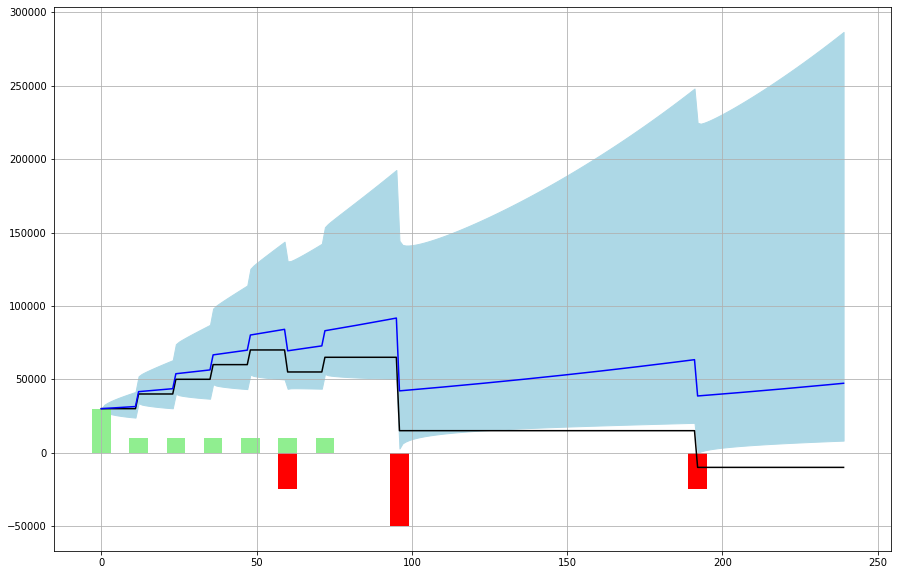

In [4]:
problem = ALM.ALMPlanner(start = "Jan 2021", end = "Jan 2041", user_risk_profile = 2)
# set planned liabilities
problem.liabilities.insert("car", "Jan 2026", 25000, 25000*0.65)
problem.liabilities.insert("university", "Jan 2029", 50000, 50000*0.95)
problem.liabilities.insert("hawaii", "Jan 2037", 25000, 25000*0.85)
# set planned assets 
problem.assets.insert("ass_0","Jan 2021",30000)
recurrent_dates = ["Jan 2022", "Jan 2023", "Jan 2024", "Jan 2025", "Jan 2026", "Jan 2027"]
for i in np.arange(len(recurrent_dates)):
    problem.assets.insert("ass_" + str(i+1),recurrent_dates[i],10000)

problem.display(bar_width = 6)

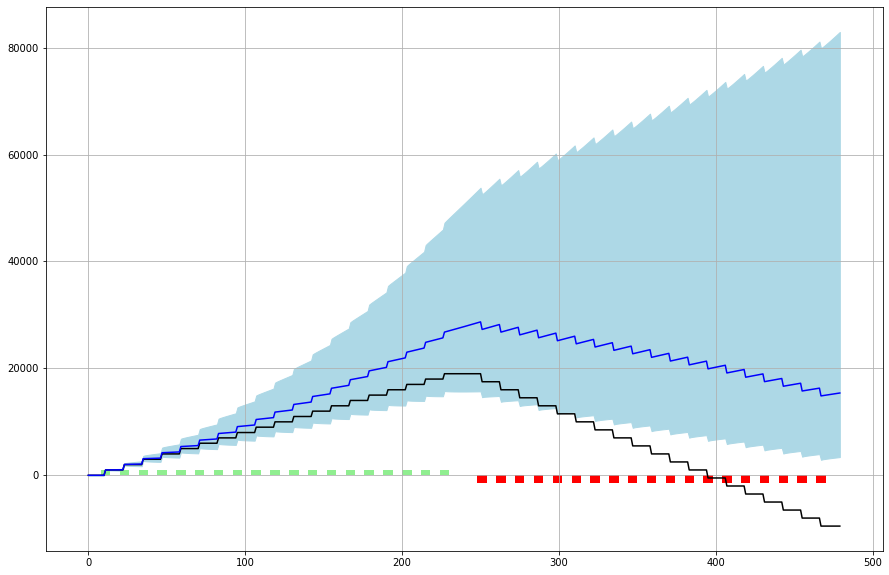

In [5]:
problem = ALM.ALMPlanner(start = "Jan 2021", end = "Jan 2061")
# set planned liabilities
recurrent_assets = pd.date_range(start = "Jan 2021", end="Jan 2040", freq = "Y")
for i in np.arange(len(recurrent_assets)):
    problem.assets.insert("ass_" + str(i+1),recurrent_assets[i],1000)
recurrent_liabilities = pd.date_range(start = "Jan 2041", end="Jan 2060", freq = "Y")
for i in np.arange(len(recurrent_liabilities)):
    problem.liabilities.insert("liab_" + str(i+1),recurrent_liabilities[i],1500,1100)

problem.display(bar_width = 6)

In [ ]:
problem.generate_model()
problem.solve()

# Display solution

In [ ]:
P = problem.P
A = problem.assets.set
L = problem.liabilities.set
N = problem.N
T = problem.T
Scenario = problem.Scenario

In [ ]:
Assets_l = {}
Assets_end = {}
for a in A:
    Assets_l[a] = np.zeros(shape = (len(L), len(P)))
    Assets_end[a] = np.zeros(shape = (len(P)))
    for p in np.arange(len(P)):
        Assets_end[a][p] = problem.solution.asset_end_part[a][P[p]]
        for l in np.arange(len(L)):
            Assets_l[a][l,p] = problem.solution.asset_part[a][L[l]][P[p]]

In [ ]:
#AssetPerETF
AssetPerETF = {}
for a in A:
    Asset_ap = np.sum(Assets_l[a], axis = 0) + Assets_end[a] 
    AssetPerETF[a] = {P[p]:Asset_ap[p] for p in np.arange(len(P))}

AssetPerETF = pd.DataFrame(AssetPerETF).transpose()
AssetPerETF.plot.bar(stacked = True, figsize = (15,10))
plt.show()

In [ ]:
AssetPerLiab = {}
for a in A:
    Asset_al = list(np.sum(Assets_l[a], axis = 1))
    Asset_al.append(np.sum(Assets_end[a]))
    L_end = list(L)
    L_end.append("end")
    AssetPerLiab[a] = {L_end[l]:Asset_al[l] for l in np.arange(len(L_end))}

AssetPerLiab = pd.DataFrame(AssetPerLiab).transpose()
AssetPerLiab.plot.bar(stacked = True, figsize = (15,10) )
plt.show()

In [ ]:
n_scen = 5
#print([solution[l][n_scen].varValue for l in Lt])
Q_nscen = np.zeros(shape = (len(P),len(L)))
Val_tl = {}
i = -1
At = sorted(list(problem.assets.period.values()))
label_period = [[k, v] for k,v in problem.assets.period.items()]
label_value = [[k, v] for k,v in problem.assets.value.items()]
period_value_df = pd.DataFrame(label_period, columns = ["Label", "Period"]).merge(pd.DataFrame(label_value, columns = ["Label", "Value"]))

for p in P:
    i = i+1
    Val_tl[p] = np.zeros(shape = (len(T), len(L)))
    for l in np.arange(len(L)):
        for t in np.arange(len(T)):
            if t < problem.liabilities.period[L[l]]:
                new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
                new_asset = [problem.solution.asset_part[a][L[l]][p] for a in new_asset_label]
                if t==0:
                    Val_tl[p][t,l] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
                else:
                    Val_tl[p][t,l] = (Val_tl[p][t-1,l] + sum(new_asset))*np.exp(Scenario[p][n_scen][t])

            elif t == problem.liabilities.period[L[l]]:
                Q_nscen[i,l] = Val_tl[p][t-1,l]
    
Val_end_t = {}
for p in P:
    Val_end_t[p] = np.zeros(shape = (len(T)))
    for t in np.arange(len(T)):
        new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
        new_asset = [problem.solution.asset_end_part[a][p] for a in new_asset_label]
        if t==0:
            Val_end_t[p][t] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
        else:
            Val_end_t[p][t] = (Val_end_t[p][t-1] + sum(new_asset))*np.exp(Scenario[p][n_scen][t])


Val_t = {}
for p in P:
    Val_t[p] = np.sum(Val_tl[p], axis = 1) + Val_end_t[p] 

AssetAllocationNominal = pd.DataFrame(Val_t)
AssetAllocationNominal[AssetAllocationNominal<0] = 0
AssetAllocationNominal.plot.area(figsize = (15,10))
plt.show()

In [ ]:
Scenario_mu = problem.Scenario_mu
#print([solution[l][n_scen].varValue for l in Lt])
Q_nscen = np.zeros(shape = (len(P),len(L)))
Val_tl = {}
i = -1
At = sorted(list(problem.assets.period.values()))
label_period = [[k, v] for k,v in problem.assets.period.items()]
label_value = [[k, v] for k,v in problem.assets.value.items()]
period_value_df = pd.DataFrame(label_period, columns = ["Label", "Period"]).merge(pd.DataFrame(label_value, columns = ["Label", "Value"]))

for p in P:
    i = i+1
    Val_tl[p] = np.zeros(shape = (len(T), len(L)))
    for l in np.arange(len(L)):
        for t in np.arange(len(T)):
            if t < problem.liabilities.period[L[l]]:
                new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
                new_asset = [problem.solution.asset_part[a][L[l]][p] for a in new_asset_label]
                if t==0:
                    Val_tl[p][t,l] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
                else:
                    Val_tl[p][t,l] = (Val_tl[p][t-1,l] + sum(new_asset))*np.exp(Scenario_mu[p])

            elif t == problem.liabilities.period[L[l]]:
                Q_nscen[i,l] = Val_tl[p][t-1,l]
    
Val_end_t = {}
for p in P:
    Val_end_t[p] = np.zeros(shape = (len(T)))
    for t in np.arange(len(T)):
        new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
        new_asset = [problem.solution.asset_end_part[a][p] for a in new_asset_label]
        if t==0:
            Val_end_t[p][t] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
        else:
            Val_end_t[p][t] = (Val_end_t[p][t-1] + sum(new_asset))*np.exp(Scenario_mu[p])


Val_t = {}
for p in P:
    Val_t[p] = np.sum(Val_tl[p], axis = 1) + Val_end_t[p] 

AssetAllocationNominal = pd.DataFrame(Val_t)
AssetAllocationNominal[AssetAllocationNominal<0] = 0
AAN_perc = AssetAllocationNominal.divide(AssetAllocationNominal.sum(axis=1), axis=0)
AssetAllocationNominal.plot.area(figsize = (15,10))
plt.margins(0,0)
plt.show()
AAN_perc.plot.area(figsize = (15,10))
plt.margins(0,0)
plt.show()

In [ ]:
Q_ln = {}
for l in L:
    Q_ln[l] = np.zeros(shape = (len(N)))
    for n in N:
        Q_ln[l][n]=problem.solution.liab_distr[l][N[n]]



for l in L:
    affordable_short = Q_ln[l] < problem.liabilities.value_tg[l]
    fail_short = Q_ln[l] < problem.liabilities.value_lb[l]
    print(np.mean(affordable_short) )
    print(np.mean(fail_short) )
    print(np.mean(Q_ln[l][affordable_short]))
    print(np.mean(Q_ln[l][Q_ln[l] <= np.quantile(Q_ln[l],1-problem.liabilities.cvar_lim[l])]))
    print(l,":", problem.liabilities.value_tg[l], ", LB:", problem.liabilities.value_lb[l], ", Solution Cvar:", np.round(np.mean(Q_ln[l][Q_ln[l] <= np.quantile(Q_ln[l],1-problem.liabilities.cvar_lim[l])]),2), ", min: ", np.min(Q_ln[l]))
